### AI Fashion Classification
## Jo Yeongtak

In [13]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import numpy as np

import tensorflow as tf
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [15]:
#Build a model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs) # ON
    #x = inputs #OFF

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [16]:
#Filter out corrupted images
num_skipped = 0
for folder_name in ("dress", "outer", "pants", "skirt", "suit", "top"):
    folder_path = os.path.join("dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        fobj = open(fpath, "rb")
        if tf.compat.as_bytes("JFIF") not in fobj.peek(10):
            num_skipped += 1
            # Delete corrupted image
            os.system("rm " + fpath)
print("Deleted %d images" % num_skipped)

Deleted 8 images


In [17]:
#Generate a Dataset
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23184 files belonging to 6 classes.
Using 18548 files for training.
Found 23184 files belonging to 6 classes.
Using 4636 files for validation.


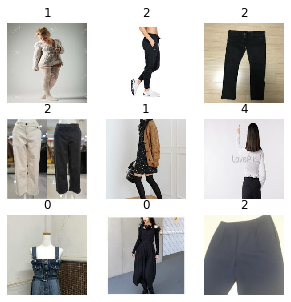

In [18]:
#Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

plt.show()

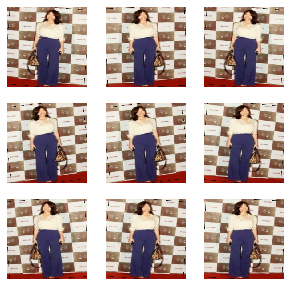

In [19]:
#Using image data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.02),
    ]
)

plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()

In [20]:
#Build a model
model = make_model(input_shape=image_size + (3,), num_classes=6)
print(str(image_size + (3,)))

keras.utils.plot_model(model, show_shapes=True)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

(180, 180, 3)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [21]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [22]:
#Train the model
epochs = 60

#callbacks = [
#    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
#]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    train_ds, epochs=epochs, callbacks=[tensorboard_callback, earlystopping], validation_data=val_ds,
) # callbacks = [tensorboard_callback, earlystopping]

Epoch 1/60
580/580 [==============================] - 82s 142ms/step - loss: 1.7627 - accuracy: 0.2897 - val_loss: 1.6327 - val_accuracy: 0.3175
Epoch 2/60
580/580 [==============================] - 82s 142ms/step - loss: 1.5097 - accuracy: 0.3944 - val_loss: 1.4075 - val_accuracy: 0.4525
Epoch 3/60
580/580 [==============================] - 84s 145ms/step - loss: 1.3536 - accuracy: 0.4725 - val_loss: 1.4665 - val_accuracy: 0.4698
Epoch 4/60
580/580 [==============================] - 83s 143ms/step - loss: 1.2213 - accuracy: 0.5323 - val_loss: 1.2859 - val_accuracy: 0.5186
Epoch 5/60
580/580 [==============================] - 82s 142ms/step - loss: 1.1323 - accuracy: 0.5703 - val_loss: 1.2489 - val_accuracy: 0.5414
Epoch 6/60
580/580 [==============================] - 82s 142ms/step - loss: 1.0494 - accuracy: 0.6094 - val_loss: 0.9966 - val_accuracy: 0.6398
Epoch 7/60
580/580 [==============================] - 92s 159ms/step - loss: 0.9979 - accuracy: 0.6294 - val_loss: 1.1442 - val_ac

In [23]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 12176), started 1:04:31 ago. (Use '!kill 12176' to kill it.)

In [125]:
p_list = { 0:"dress", 1:"outer", 2:"pants", 3:"skirt", 4:"suit", 5:"top"}

#Prediction Sample Image
img = keras.preprocessing.image.load_img(
    "example/mtb12.PNG", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
result = np.argmax(predictions[0])

for i in range(np.shape(predictions)[1]):
    print(p_list[i], round(predictions[0][i] * 100, 2))

dress 12.61
outer 0.0
pants 0.0
skirt 65.7
suit 0.0
top 21.69


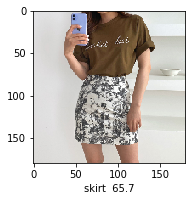

In [126]:
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap=plt.cm.binary)
plt.xlabel(str(p_list[result]) + '  ' + str(round((np.max(predictions) * 100), 2)))
plt.show()